# IMPORTS

In [101]:
import math
import pandas as pd
import inflection
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 20,10

import seaborn as sns

from IPython.core.display import HTML
from IPython.display import Image

import datetime

## Loading data

In [102]:
df_sales_raw = pd.read_csv( '../data/train.csv', low_memory=False )
df_stores_raw = pd.read_csv( '../data/store.csv', low_memory=False )

In [103]:
df_sales_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [104]:
df_stores_raw

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [105]:
df_raw = pd.merge( df_sales_raw, df_stores_raw, how='left', on='Store')

In [106]:
# Checking if the merging went fine
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
162297,623,7,2015-03-08,0,0,0,0,0,0,a,a,4080.0,3.0,2011.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


# DATA DESCRIPTION

In [107]:
# Making a security copy
df2 = df_raw.copy()

## Renaming columns

In [108]:
df2.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [109]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old ))

df2.columns = cols_new

In [110]:
# Checking whether the renaming went fine
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Data dimensions

In [111]:
print( 'Number of rows: {}'.format( df2.shape[0] ) )
print( 'Number of columns: {}'.format( df2.shape[1] ) )

Number of rows: 1017209
Number of columns: 18


## Data types

In [112]:
df2['date'] = pd.to_datetime( df2['date'] )
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Checking NAs

In [113]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Filling out NAs

In [114]:
# competition_distance
df2['competition_distance'].max()

75860.0

In [115]:
# Filling NaN with a value much bigger than the maximum above
df2['competition_distance'] = df2['competition_distance'].apply(lambda x: 300000 if math.isnan(x) else x)
df2['competition_distance'].isna().sum()

0

In [116]:
#competition_open_since_month
df2['competition_open_since_month'] = df2.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year
df2['competition_open_since_year'] = df2.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week
df2['promo2_since_week'] = df2.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

#promo2_since_year
df2['promo2_since_year'] = df2.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

In [117]:
#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df2['month_map'] = df2['date'].dt.month.map( month_map )

df2['promo_interval'].fillna( 0, inplace=True )

df2['is_promo2'] =  df2[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'] else 0, axis=1)

In [118]:
df2.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo2                       0
dtype: int64

## Data types (2)

In [119]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo2                                int64
dtype: object

In [120]:
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype( np.int64 )
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype( np.int64 )
df2['promo2_since_week'] = df2['promo2_since_week'].astype( np.int64 )
df2['promo2_since_year'] = df2['promo2_since_year'].astype( np.int64 )

In [121]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo2                                int64
dtype: object

## Descriptive statistics

In [122]:
num_attributes = df2.select_dtypes( include=['int64','float64'] )
cat_attributes = df2.select_dtypes( exclude=['int64','float64','datetime64[ns]'] )

### Numerical attributes

In [123]:
# Central tendency
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.min() ).T
d3 = pd.DataFrame( num_attributes.max() ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.skew() ).T
d6 = pd.DataFrame( num_attributes.kurtosis() ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [124]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,300000.0,299980.0,6195.172978,2330.0,16856.983808,14.003340,237.337110
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


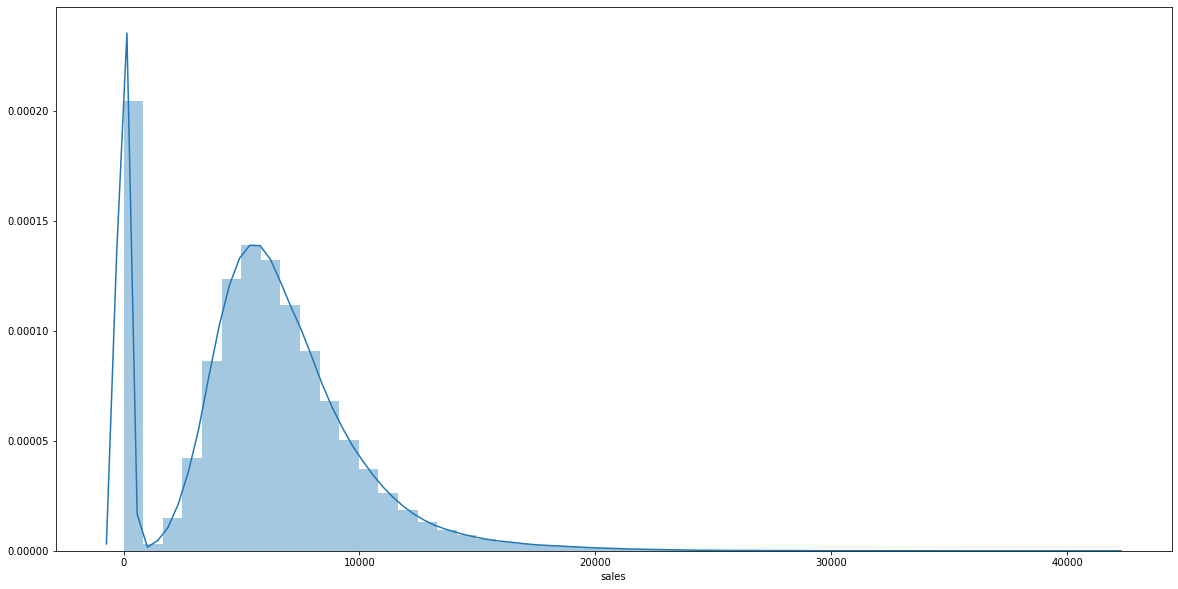

In [125]:
sns.distplot( df2['sales'] );

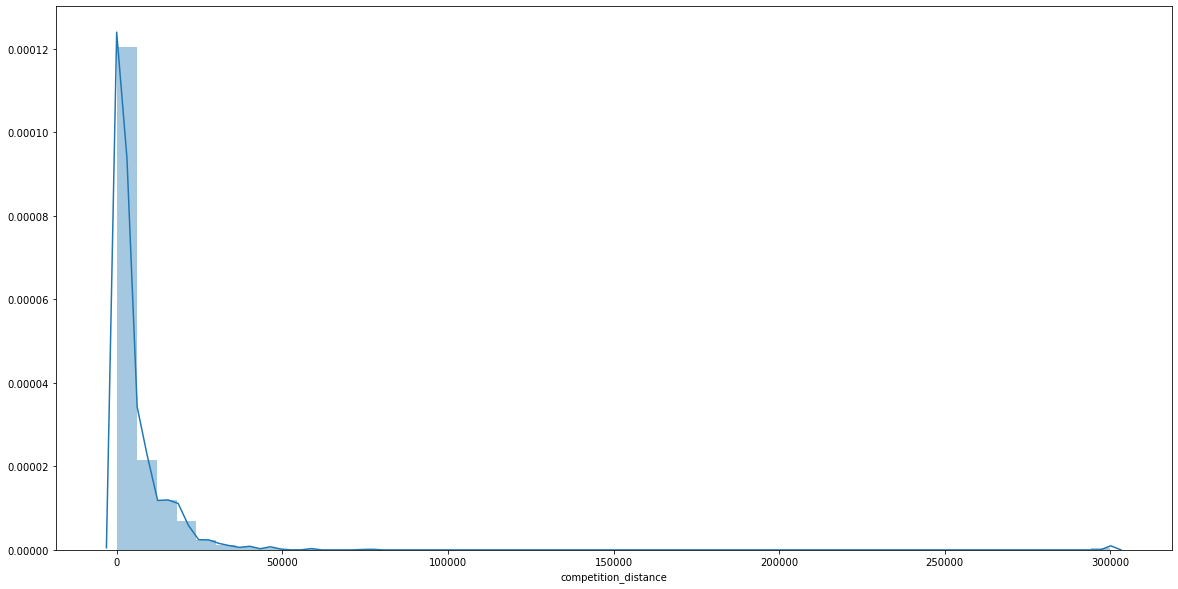

In [126]:
sns.distplot( df2['competition_distance'] );

### Categorial attributes

In [127]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

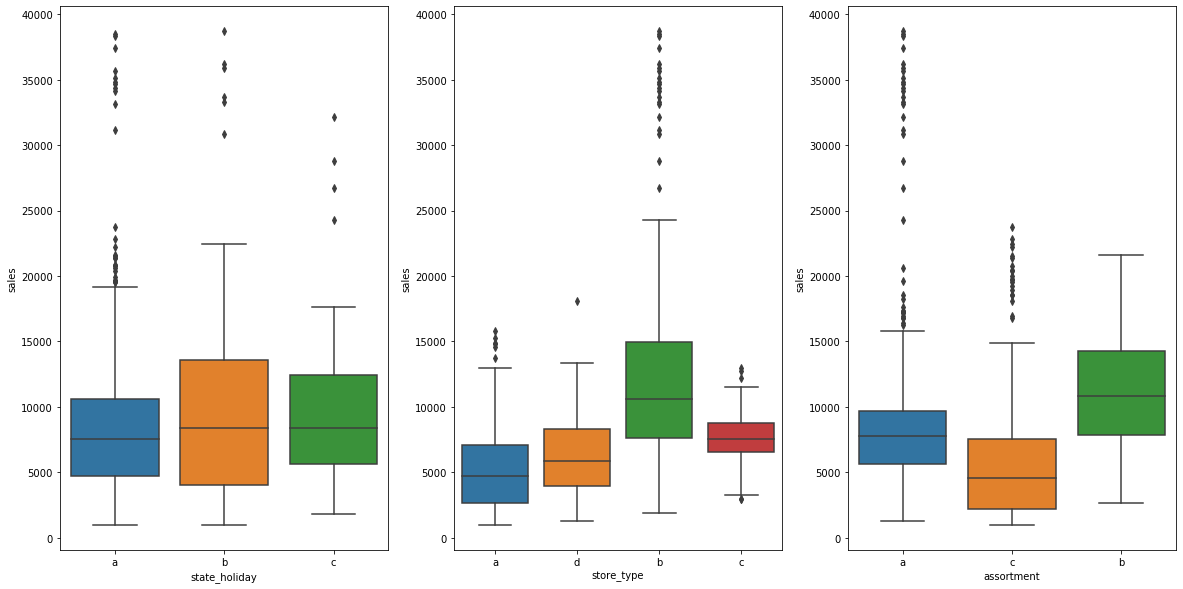

In [128]:
aux1 = df2[( df2['state_holiday'] != '0' ) & ( df2['sales'] > 0 )]

plt.subplot(1, 3, 1);
sns.boxplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot(1, 3, 2);
sns.boxplot( x='store_type', y='sales', data=aux1 );

plt.subplot(1, 3, 3);
sns.boxplot( x='assortment', y='sales', data=aux1 );

# FEATURE ENGINEERING

*In order to come up with business hypotheses, we start with a mind map of the problem, its agents and influencing factors*

In [129]:
df3 = df2.copy()

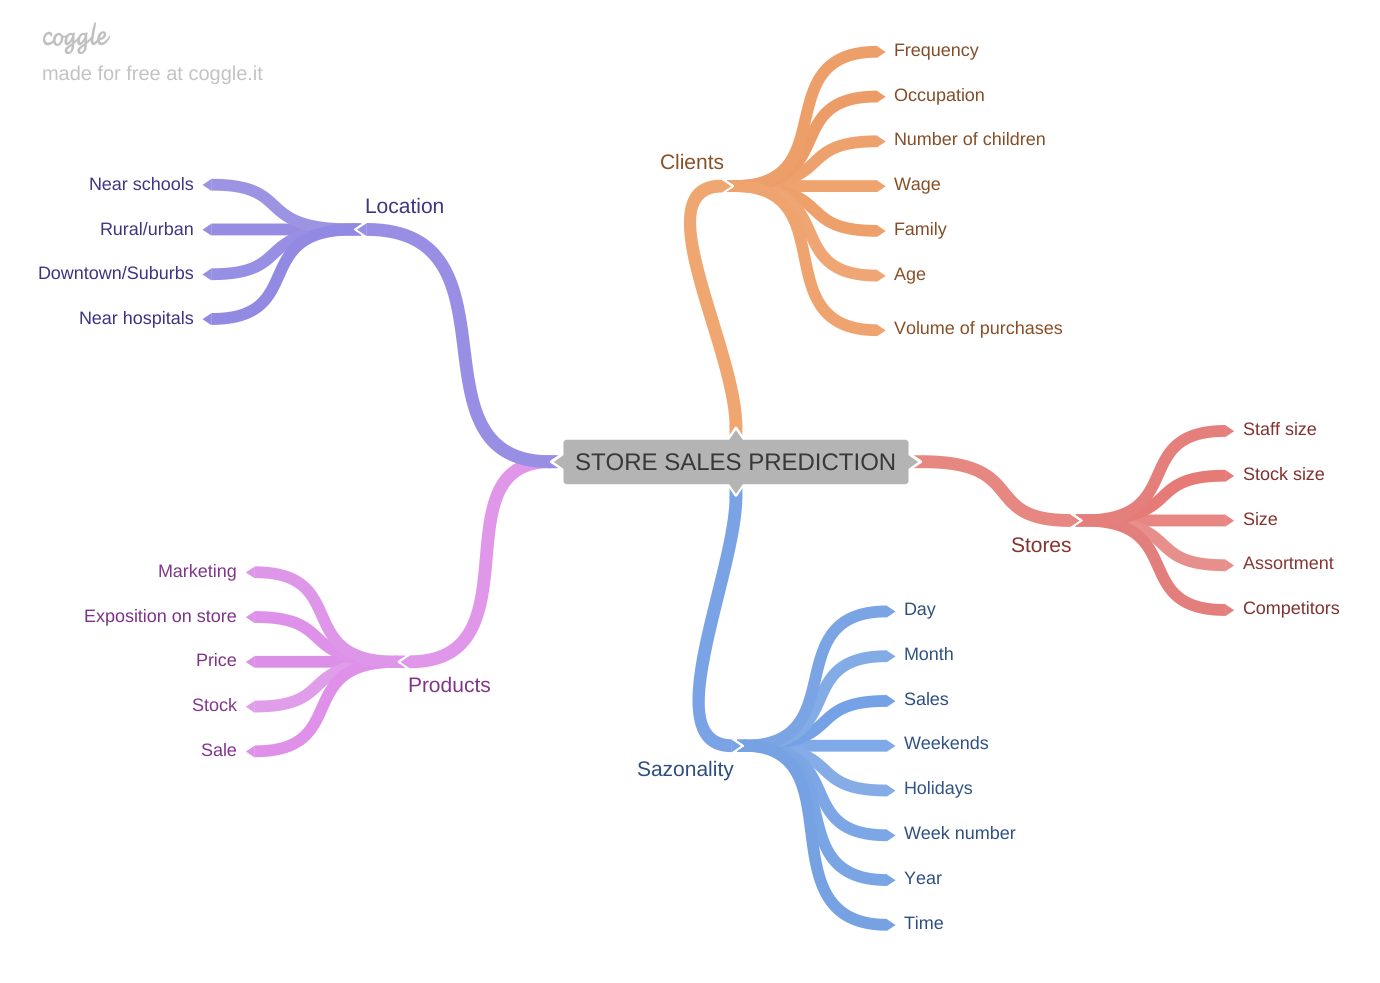

In [130]:
Image( '../imgs/STORE_SALES_PREDICTION.png', width=900 )

## Creation of the hypoteshes

### Stores

**Bigger revenue if:**

**1.** Bigger staff size

**2.** Bigger stock size 

**3.** Larger stores

**4.** Greater assortment

**5.** Older competitors

**Smaller revenue if:**

**6.** Closer competitors

### Products

**Bigger revenue if:**

**1.** Greater marketing investment 

**2.** Better exposition at store 

**3.** Lower prices 

**4.** More agressive sales

**5.** Sales kept for longer periods

**6.** More sales days

**7.** More consecutive sales

### Sazonality

**Smaller revenue during:**

**1.** School holidays

**2.** Weekends
     
**Bigger revenue:**

**3.** If open during Christmas 

**4.** With the passage of years

**5.** On the 2nd semester of each year

**6.** After the 10th day of each month

## Final list of hypotheses
*Selecting from the above only the ones possible with the current features*

*Remaining ones are postponed for future cycles of CRISP-DM*

**1.** Greater assortment $\Rightarrow$ bigger revenue

**2.** Older competitors $\Rightarrow$ bigger revenue

**3.** Closer competitors $\Rightarrow$ lower revenue

**4.** Sales kept for longer periods $\Rightarrow$ bigger revenue

**5.** More sales days $\Rightarrow$ bigger revenue

**6.** More consecutive sales $\Rightarrow$ bigger revenue

**7.** School holidays $\Rightarrow$ lower revenue

**8.** Weekends $\Rightarrow$ lower revenue

**9.** If open during Christmas $\Rightarrow$ bigger revenue

**10.** With the passage of years $\Rightarrow$ bigger revenue

**11.** On the 2nd semester of each year $\Rightarrow$ bigger revenue

**12.** After the 10th day of each mont $\Rightarrow$ bigger revenue

## Feature engineering

In [131]:
# year
df3['year'] = df3['date'].dt.year

# month
df3['month'] = df3['date'].dt.month

# day
df3['day'] = df3['date'].dt.day

# week of year
df3['week_of_year'] = df3['date'].dt.weekofyear

# year week
df3['year_week'] = df3['date'].dt.strftime( '%Y-%W' )

# competition since
df3['competition_since'] = df3.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
# competition time (months)
df3['competition_time_month'] = ( ( df3['date'] - df3['competition_since'] )/30 ).dt.days

# promo since
df3['promo_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
df3['promo_since'] = df3['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( weeks=1 ) )
# promo time (weeks)
df3['promo_time_week'] = ( ( df3['date'] - df3['promo_since'] )/7 ).dt.days

# assortment
df3['assortment'] = df3['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended' )

# state holiday
df3['state_holiday'] = df3['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# FILTERING VARIABLES

*Ruling out a subset of the data due to business restrictions*

In [132]:
df4 = df3.copy()

In [133]:
df4.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## Filtering rows

In [134]:
# Information about closed stores are not actually useful here 
# Moreover, only data for which sales occurred are really relevant
df4 = df4.loc[(df4['open'] != 0) & (df4['sales'] > 0)]

## Selecting columns

In [135]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df4.drop( columns=cols_drop, inplace=True )

In [136]:
df4.sample()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo2,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
247036,444,6,2014-12-20,22971,0,regular_day,0,c,basic,1700.0,...,0,2014,12,20,51,2014-50,2009-11-01,62,2014-12-15,0


# <span style="color:orange">EDA</span>

In [137]:
df5 = df4.copy()

## Univariate analysis

### Response variable

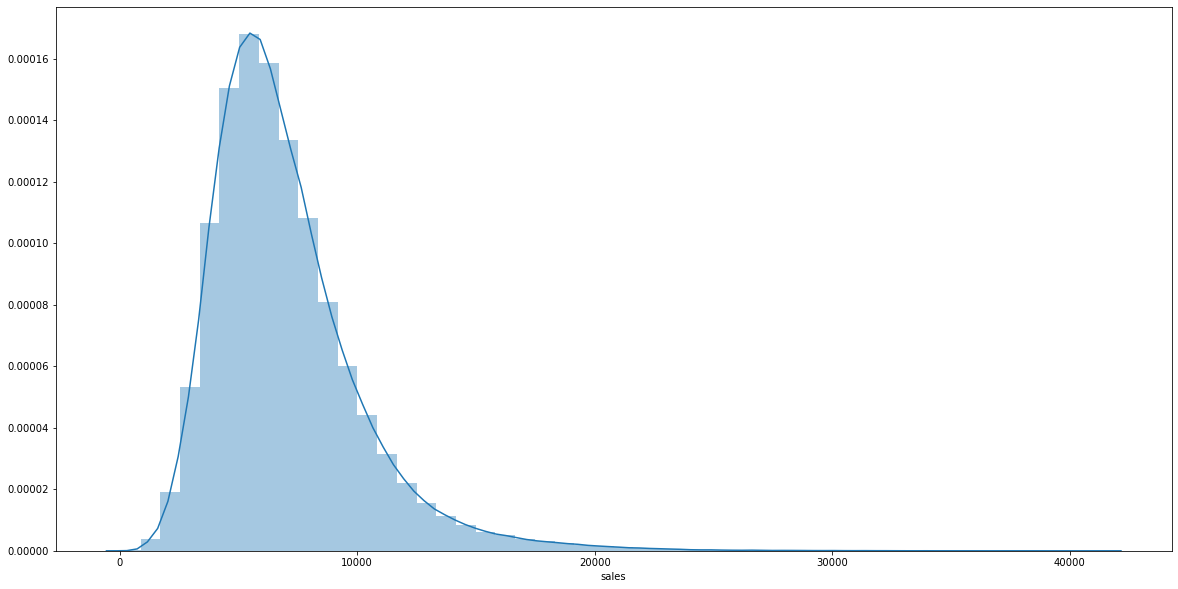

In [138]:
sns.distplot( df5['sales'] );

### Numerical variables

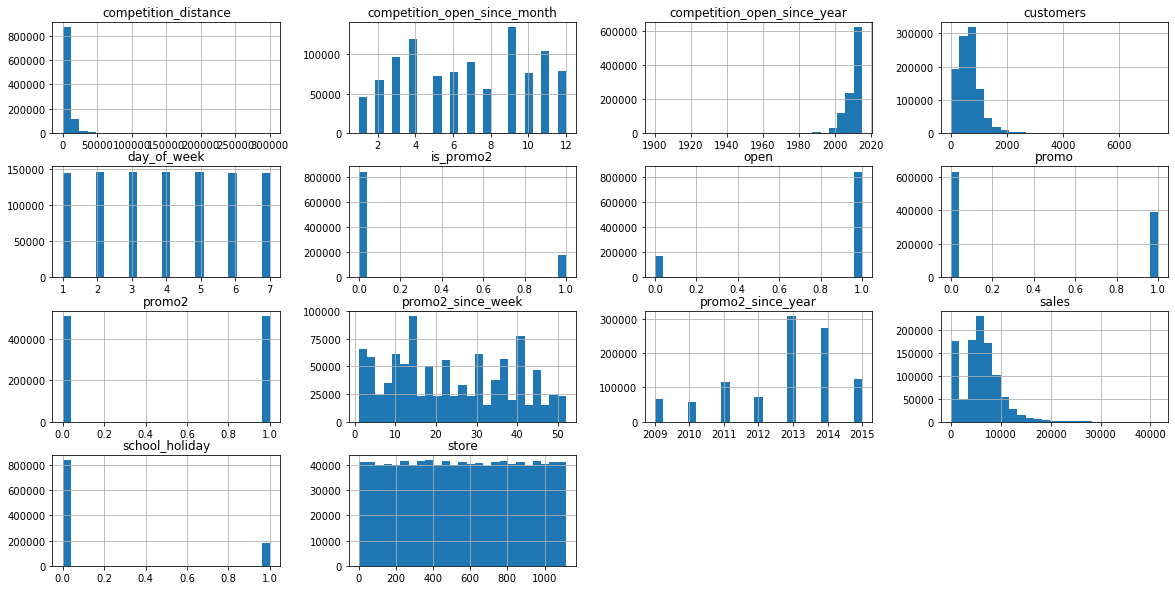

In [139]:
num_attributes.hist( bins=25 );

### Categorical variables

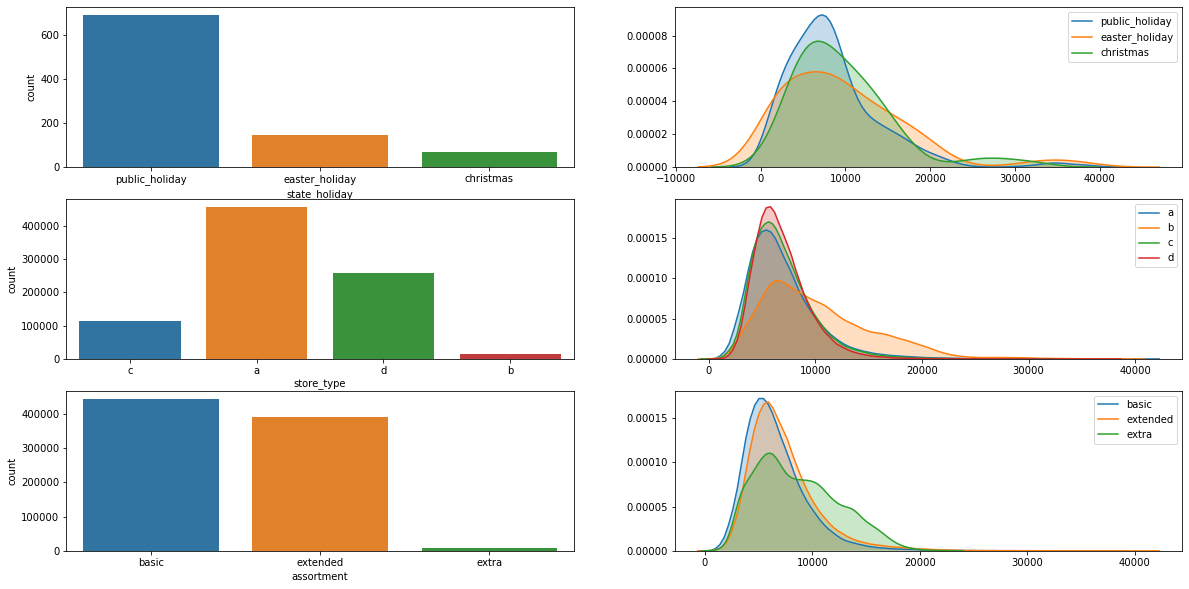

In [140]:
#state_holiday
a = df5[df5['state_holiday'] != 'regular_day']
plt.subplot(3, 2, 1)
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot( df5[df5['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df5[df5['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df5[df5['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

#store_type
plt.subplot(3, 2, 3)
sns.countplot(df5['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot( df5[df5['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df5[df5['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df5[df5['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df5[df5['store_type'] == 'd']['sales'], label='d', shade=True )


#assortment
plt.subplot(3, 2, 5)
sns.countplot(df5['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot( df5[df5['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df5[df5['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df5[df5['assortment'] == 'extra']['sales'], label='extra', shade=True )

## <span style="color:orange">Bivariate analysis</span>
*Validating the hypotheses arised earlier*

### Greater assortment $\Rightarrow$ bigger revenue
_**<span style="color:red">False:</span>**_ **Stores with more ('extra') assortment sell less**

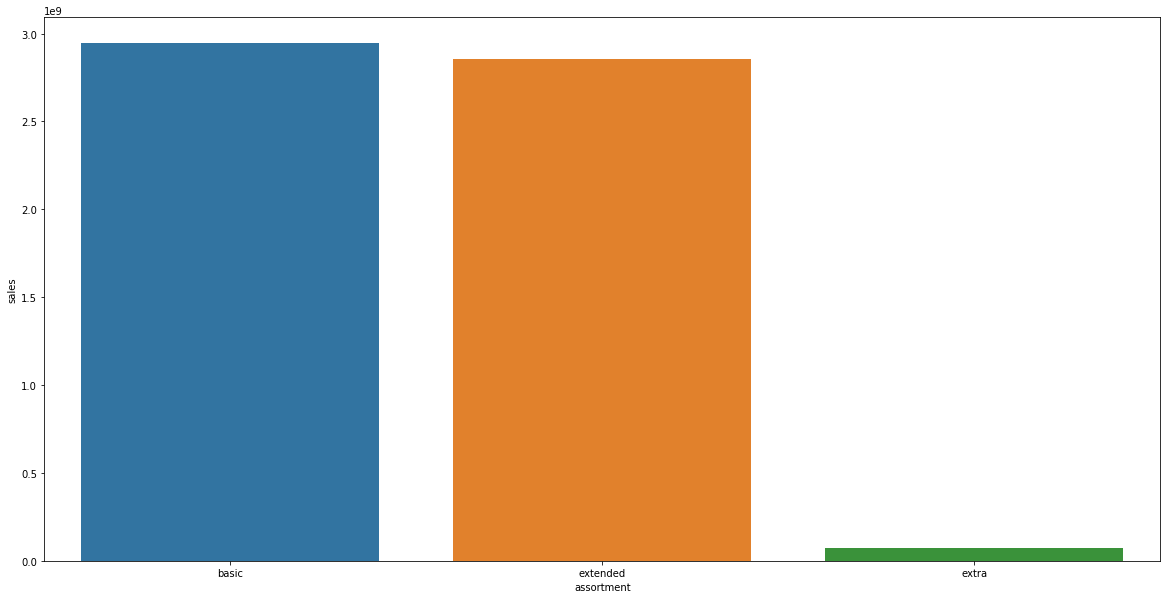

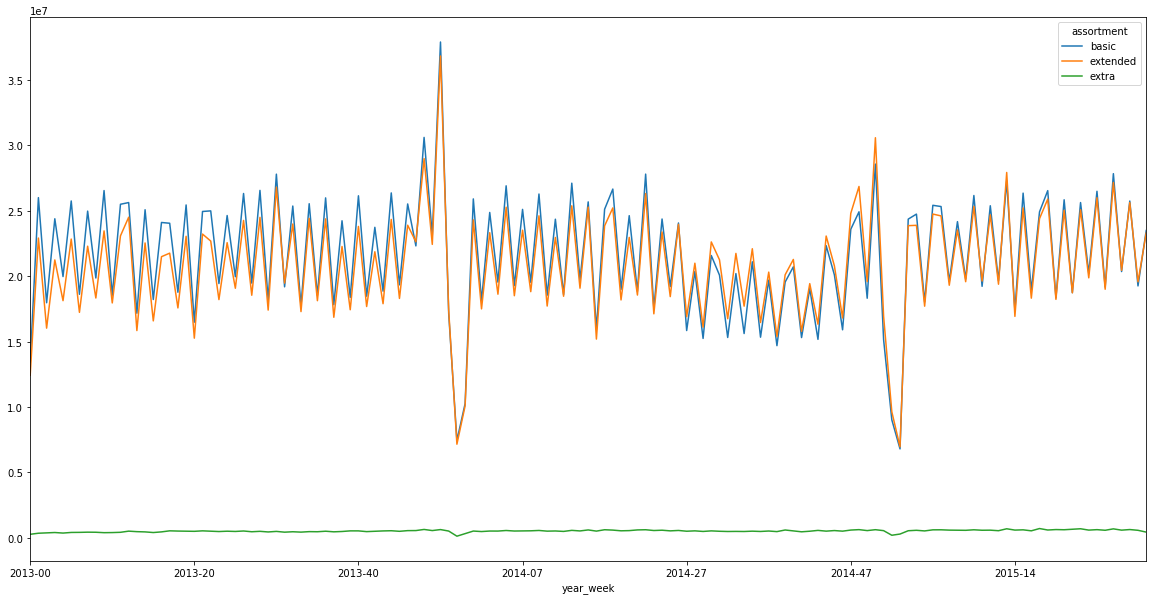

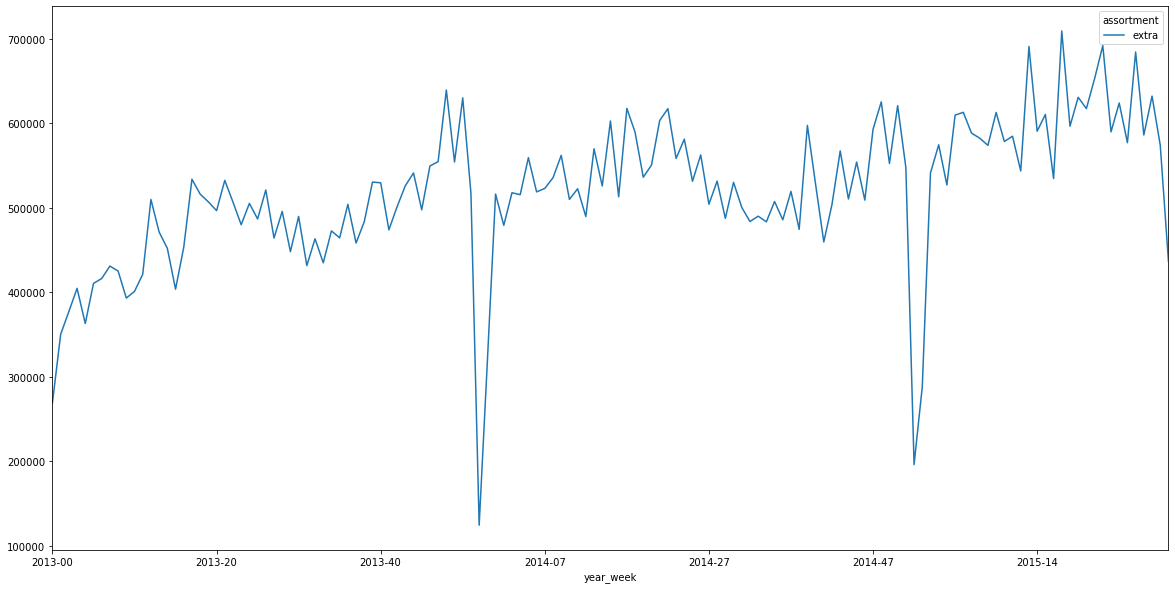

In [141]:
aux1 = df5[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df5[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();

### Older competitors $\Rightarrow$ bigger revenue
_**<span style="color:red">False:</span>**_ **Stores with older competitors sell less**

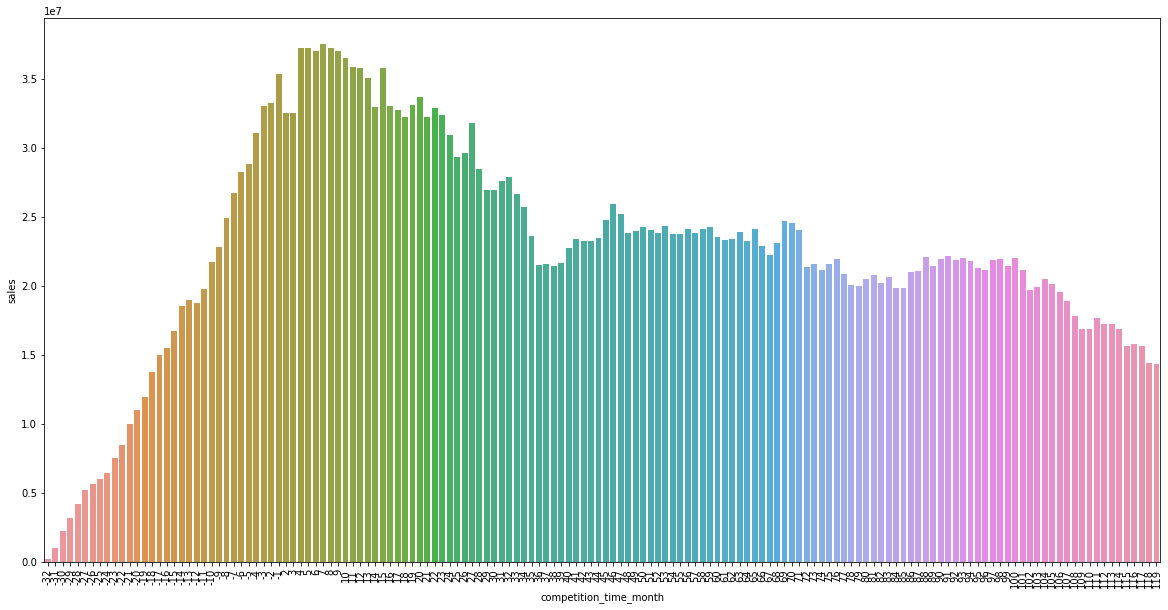

In [142]:
aux7 = df5.loc[:,['competition_time_month','sales']].groupby( 'competition_time_month' ).sum().reset_index()

# In the following, I exclude '0' and '1' since they might come from the previous substitution of NA values 
#                                                                         for 'competition_since' variables
# It is not guaranteed whether I am also excluding previously OK (not NA) data

aux8 = aux7.loc[(aux7['competition_time_month'] < 120) & (aux7['competition_time_month'] != 0) & (aux7['competition_time_month'] != 1),:]
sns.barplot( x='competition_time_month', y='sales', data=aux8 );
plt.xticks( rotation=90 );

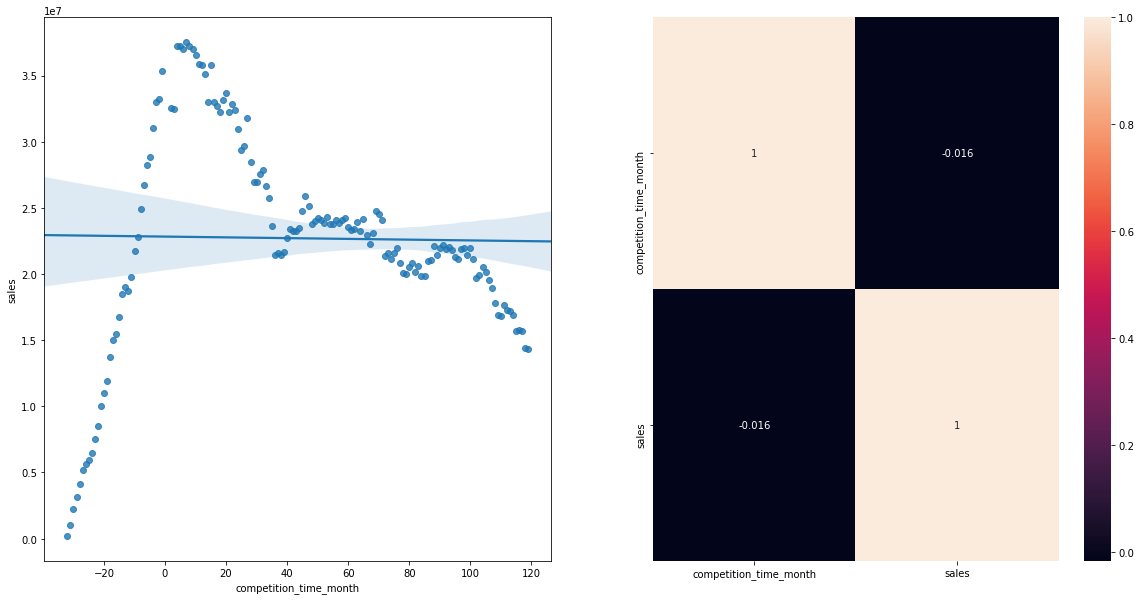

In [143]:
plt.subplot(1,2,1);
sns.regplot( x='competition_time_month', y='sales', data=aux8 );


plt.subplot(1,2,2);
sns.heatmap( aux8.corr(method='pearson'), annot=True );

### Closer competitors $\Rightarrow$ lower revenue
_**<span style="color:red">False:</span>**_ **Stores with competitors in a smaller range seem to sell more! _(this is an unexpected insight)_**

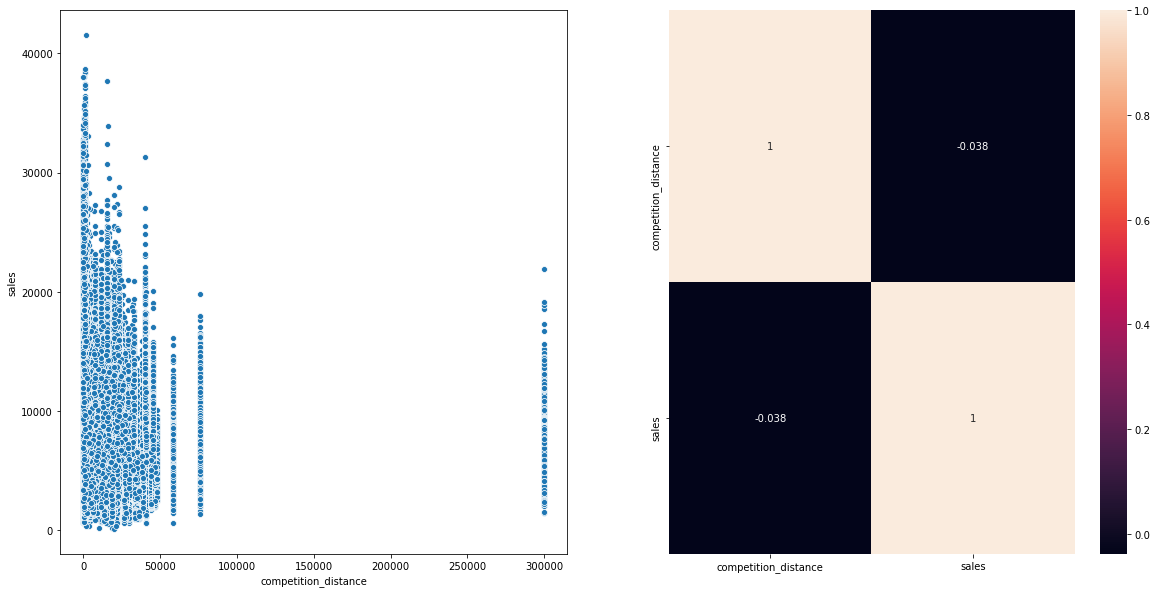

In [144]:
aux4 = df5.loc[:,['competition_distance','sales']]
plt.subplot(1,2,1)
sns.scatterplot( x='competition_distance', y='sales', data=aux4 );

plt.subplot(1,2,2)
sns.heatmap( aux4.corr( method='pearson' ), annot=True );

*Or barplots, divided in 2 subplots to streamline visualization*

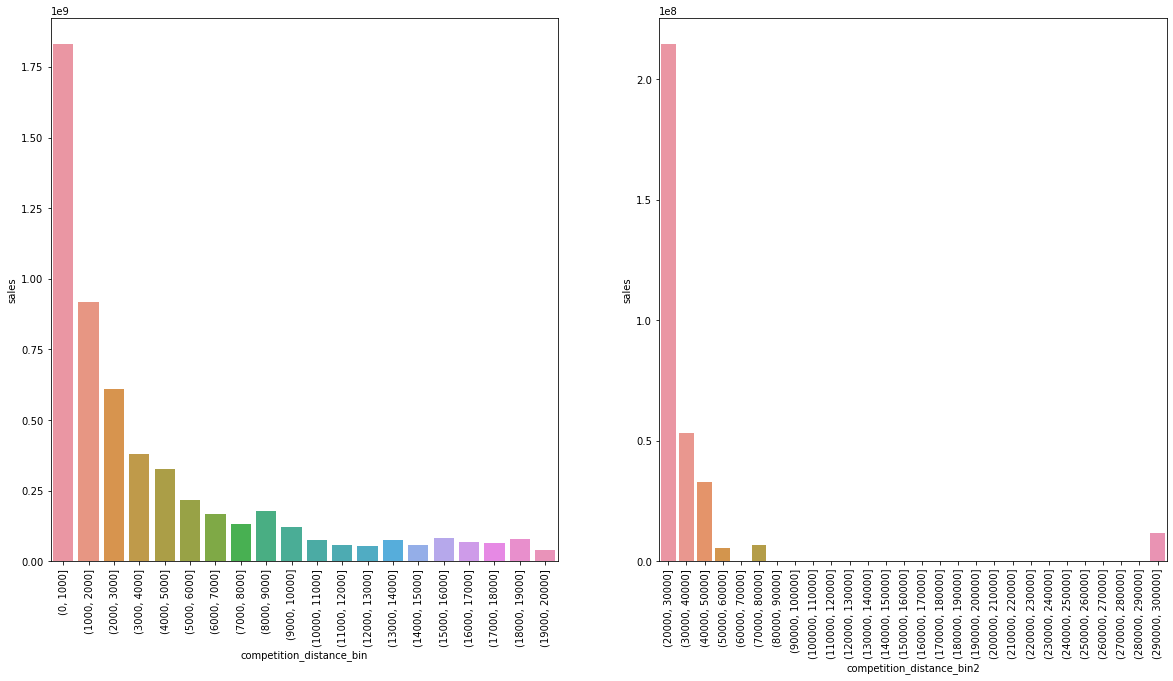

In [145]:
bins = list( np.arange( 0, 20001, 1000 ) )
aux4['competition_distance_bin'] = pd.cut(aux4.loc[:,'competition_distance'], bins=bins)

aux5 = aux4.groupby( 'competition_distance_bin' ).sum().reset_index()
plt.subplot(1,2,1)
sns.barplot( aux5['competition_distance_bin'], aux5['sales'] );
plt.xticks( rotation=90 );



bins2 = list( np.arange( 20000, 300001, 10000 ) )
aux4['competition_distance_bin2'] = pd.cut(aux4.loc[:,'competition_distance'], bins=bins2)

aux6 = aux4.groupby( 'competition_distance_bin2' ).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot( aux6['competition_distance_bin2'], aux6['sales'] );
plt.xticks( rotation=90 );

### <span style="color:orange">(next hypothesis)</span>

## <span style="color:red">Multivariate analysis</span>

# <span style="color:red">DATA PREPARATION</span> 